In [1]:
import numpy as np
import pandas as pd
from pathlib import Path
from IPython.display import display

import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import matplotlib.colors as mcolors
from matplotlib.cm import ScalarMappable

%matplotlib inline
plt.rcParams["figure.dpi"] = 120
plt.rcParams["axes.spines.top"] = False
plt.rcParams["axes.spines.right"] = False

In [2]:
def try_read_csv(p: Path):
    try:
        return pd.read_csv(p, low_memory=False, encoding="utf-8")
    except UnicodeDecodeError:
        return pd.read_csv(p, low_memory=False, encoding="latin-1")

# Prefer relative ./Dataset next to the notebook
candidates = []
for folder in [Path("Dataset"),
               Path(r"C:\Users\ROG\Desktop\Project2\Dataset")]:
    if folder.exists():
        candidates += list(folder.rglob("*.csv"))

if not candidates:
    raise FileNotFoundError("No CSV found under ./Dataset or the Project2 path.")

csv_path = candidates[0]
df = try_read_csv(csv_path)
print("Loaded:", csv_path)

display(df.head(3))

Loaded: Dataset\superstore.csv


,Category,City,Country,Customer.ID,Customer.Name,Discount,Market,记录数,Order.Date,Order.ID,...,Sales,Segment,Ship.Date,Ship.Mode,Shipping.Cost,State,Sub.Category,Year,Market2,weeknum
0,Office Supplies,Los Angeles,United States,LS-172304,Lycoris Saunders,0.0,US,1,2011-01-07 00:00:00.000,CA-2011-130813,...,19,Consumer,2011-01-09 00:00:00.000,Second Class,4.37,California,Paper,2011,North America,2
1,Office Supplies,Los Angeles,United States,MV-174854,Mark Van Huff,0.0,US,1,2011-01-21 00:00:00.000,CA-2011-148614,...,19,Consumer,2011-01-26 00:00:00.000,Standard Class,0.94,California,Paper,2011,North America,4
2,Office Supplies,Los Angeles,United States,CS-121304,Chad Sievert,0.0,US,1,2011-08-05 00:00:00.000,CA-2011-118962,...,21,Consumer,2011-08-09 00:00:00.000,Standard Class,1.81,California,Paper,2011,North America,32


In [3]:
def pick(df, names):
    for n in names:
        if n in df.columns: return n
        for c in df.columns:
            if c.lower() == n.lower(): return c
    return None

col_region    = pick(df, ["Region","region","Market","market"])
col_market    = pick(df, ["Market","market"])
col_category  = pick(df, ["Category","category"])
col_subcat    = pick(df, ["Sub.Category","sub_category","Sub-Category"])
col_sales     = pick(df, ["Sales","sales"])
col_profit    = pick(df, ["Profit","profit"])
col_discount  = pick(df, ["Discount","discount"])
col_shipmode  = pick(df, ["Ship.Mode","ship_mode"])
col_shipcost  = pick(df, ["Shipping.Cost","shipping_cost"])
col_qty       = pick(df, ["Quantity","quantity"])
col_orderdate = pick(df, ["Order.Date","order_date","OrderDate","Order_Date"])
col_year      = pick(df, ["Year","year"])

# Numerics
for c in [col_sales, col_profit, col_discount, col_shipcost, col_qty]:
    if c and df[c].dtype.kind not in "iufc":
        df[c] = pd.to_numeric(df[c], errors="coerce")

# Base metric
df = df[df[col_sales] > 0].copy()
df["profit_margin"] = df[col_profit] / df[col_sales]
df = df[(df["profit_margin"] > -1) & (df["profit_margin"] < 1)]
print("Rows after cleaning:", len(df))

# Health check
check_cols = {
    "region": col_region, "category": col_category, "subcat": col_subcat,
    "sales": col_sales, "profit": col_profit, "discount": col_discount,
    "ship_mode": col_shipmode, "ship_cost": col_shipcost, "order_date": col_orderdate
}
print("\nNon-null / unique counts:")
for k, c in check_cols.items():
    if c is None:
        print(f" - {k:<10} <missing>")
    else:
        nn = int(df[c].notna().sum()); uq = int(df[c].nunique(dropna=True))
        print(f" - {k:<10} {c:<18} non-null={nn:>6}, unique={uq:>6}")

Rows after cleaning: 49029

Non-null / unique counts:
 - region     Region             non-null= 49029, unique=    13
 - category   Category           non-null= 49029, unique=     3
 - subcat     Sub.Category       non-null= 49029, unique=    17
 - sales      Sales              non-null= 49029, unique=  2241
 - profit     Profit             non-null= 49029, unique= 22922
 - discount   Discount           non-null= 49029, unique=    26
 - ship_mode  Ship.Mode          non-null= 49029, unique=     4
 - ship_cost  Shipping.Cost      non-null= 49029, unique= 16675
 - order_date Order.Date         non-null= 49029, unique=  1430


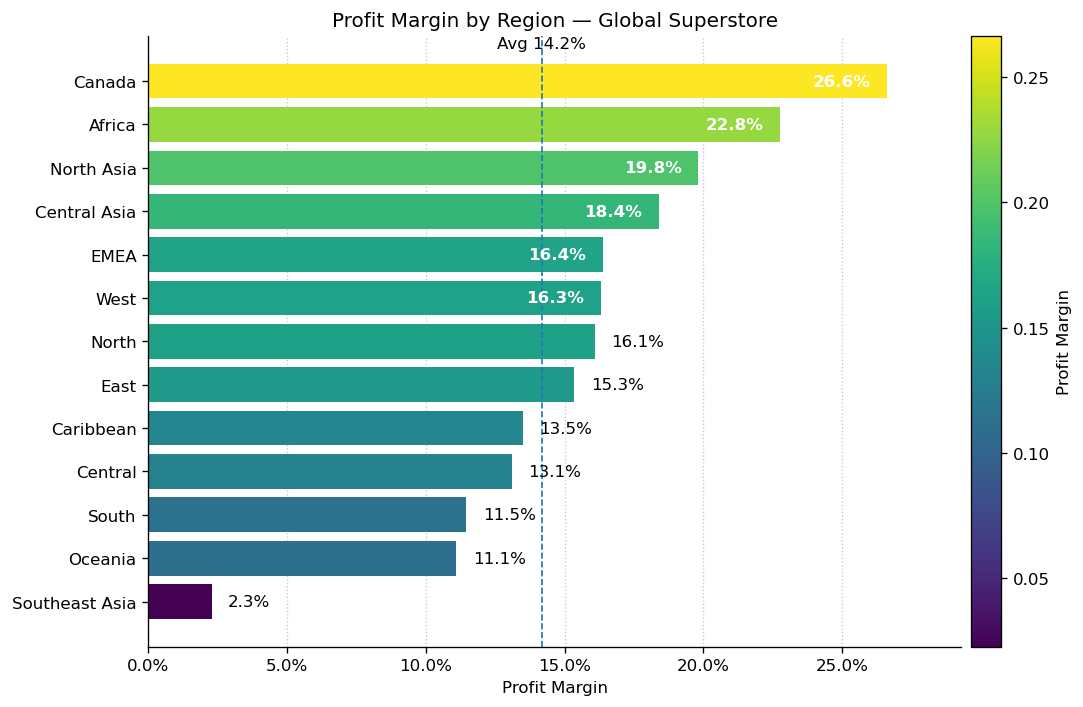

In [4]:
# Aggregate by region (you may switch to Market by setting col_region = col_market)
region = (df.groupby(col_region)
            .agg(sales=(col_sales,"sum"), profit=(col_profit,"sum"))
            .reset_index())
region["margin"] = region["profit"] / region["sales"]
region = region.sort_values("margin", ascending=False).reset_index(drop=True)

avg_margin = (df[col_profit].sum() / df[col_sales].sum())

fig, ax = plt.subplots(figsize=(9.5, 6))
y = np.arange(len(region))

# Color by margin via new colormaps API (no deprecation warnings)
cmap = mpl.colormaps['viridis']
norm = mcolors.Normalize(vmin=region["margin"].min(), vmax=region["margin"].max())
colors = cmap(norm(region["margin"].values))

ax.barh(y, region["margin"], color=colors)
ax.set_yticks(y)
ax.set_yticklabels(region[col_region])
ax.xaxis.set_major_formatter(mtick.PercentFormatter(1.0))
ax.set_xlabel("Profit Margin")
ax.set_title("Profit Margin by Region — Global Superstore")
ax.set_axisbelow(True)
ax.grid(axis="x", linestyle=":", linewidth=0.8, alpha=0.7)

ax.axvline(avg_margin, linestyle="--", linewidth=1)
ax.text(avg_margin, -0.7, f"Avg {avg_margin*100:.1f}%", ha="center", va="bottom")

xmax = float(region["margin"].max())
for i, v in enumerate(region["margin"]):
    label = f"{v*100:.1f}%"
    if v >= avg_margin + 0.02:
        ax.text(v - 0.006, i, label, va="center", ha="right", color="white", fontsize=10, fontweight="bold")
    else:
        ax.text(min(v + 0.006, xmax*1.02), i, label, va="center", ha="left", fontsize=10)

ax.invert_yaxis()
ax.set_xlim(0, xmax*1.10)

sm = ScalarMappable(cmap=cmap, norm=norm); sm.set_array([])
cbar = fig.colorbar(sm, ax=ax, pad=0.01); cbar.set_label("Profit Margin")

plt.tight_layout(); plt.show()

In [5]:
print("Legend:")
print("Bars show profit margin (Profit/Sales) by region, sorted high→low.")
print("Bar color encodes margin (viridis); dashed line = overall average; labels are percentages.")

top2 = region.head(2); bot2 = region.tail(2)
gap = top2["margin"].iloc[0] - bot2["margin"].iloc[-1]
above = (region["margin"] > avg_margin).sum(); below = len(region) - above

print("\nFindings:")
print(f"• Highest-margin regions: {top2[col_region].iloc[0]} ({top2['margin'].iloc[0]*100:.1f}%), "
      f"{top2[col_region].iloc[1]} ({top2['margin'].iloc[1]*100:.1f}%).")
print(f"• Lowest-margin regions: {bot2[col_region].iloc[0]} ({bot2['margin'].iloc[0]*100:.1f}%), "
      f"{bot2[col_region].iloc[1]} ({bot2['margin'].iloc[1]*100:.1f}%).")
print(f"• Spread between highest and lowest: {gap*100:.1f} percentage points.")
print(f"• Above average: {above}; below average: {below}.")
print(f"• Overall average margin (dashed line): {avg_margin*100:.1f}%.")


Legend:
Bars show profit margin (Profit/Sales) by region, sorted high→low.
Bar color encodes margin (viridis); dashed line = overall average; labels are percentages.

Findings:
• Highest-margin regions: Canada (26.6%), Africa (22.8%).
• Lowest-margin regions: Oceania (11.1%), Southeast Asia (2.3%).
• Spread between highest and lowest: 24.3 percentage points.
• Above average: 8; below average: 5.
• Overall average margin (dashed line): 14.2%.


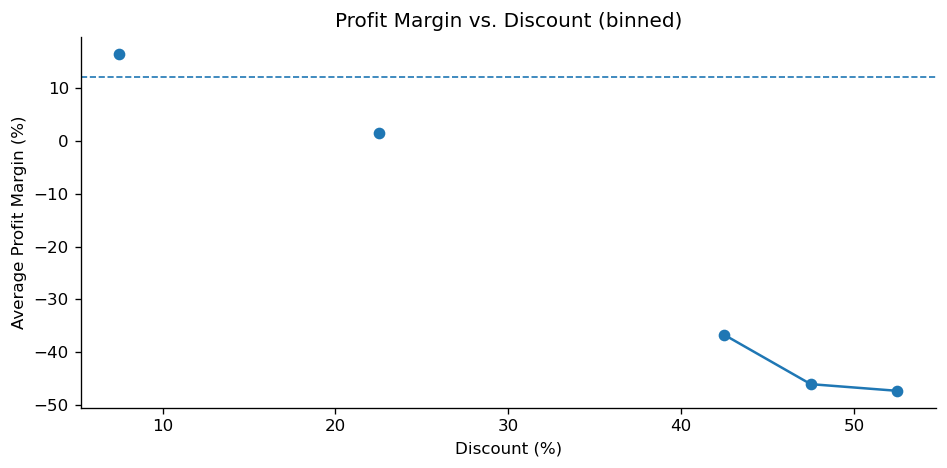

Global Spearman corr(Discount, profit_margin) = -0.598

Regions with strongest negative association (top 5):


Southeast Asia   -0.740694
EMEA             -0.686215
South            -0.655965
Central          -0.610261
North            -0.606610
dtype: float64


Regions with weakest/positive association (top 5):


East           -0.564768
Central Asia   -0.561853
North Asia     -0.498148
West           -0.430712
Africa         -0.065234
dtype: float64

In [6]:
if col_discount:
    tmp = df[[col_discount, "profit_margin", col_region]].dropna()
    tmp = tmp[(tmp[col_discount] >= 0) & (tmp[col_discount] <= 0.6)]
    corr_global = tmp[[col_discount, "profit_margin"]].corr(method="spearman").iloc[0,1] if len(tmp) else np.nan

    if len(tmp) >= 20:
        bins = np.arange(0, 0.65, 0.05)
        labels = (bins[:-1] + bins[1:]) / 2
        tmp["_disc_bin"] = pd.cut(tmp[col_discount], bins=bins, include_lowest=True)
        curve = (tmp.groupby("_disc_bin", observed=False)["profit_margin"]
                   .mean().reindex(pd.IntervalIndex.from_breaks(bins)))
        if curve.notna().sum() >= 2:
            x = labels[:len(curve)]
            plt.figure(figsize=(8,4))
            plt.plot(x*100, curve.values*100, marker="o")
            plt.axhline((df["profit_margin"].mean())*100, linestyle="--", linewidth=1)
            plt.title("Profit Margin vs. Discount (binned)")
            plt.xlabel("Discount (%)"); plt.ylabel("Average Profit Margin (%)")
            plt.tight_layout(); plt.show()
        else:
            plt.figure(figsize=(8,4))
            plt.scatter(tmp[col_discount]*100, tmp["profit_margin"]*100, s=10, alpha=0.4)
            plt.axhline((df["profit_margin"].mean())*100, linestyle="--", linewidth=1)
            plt.title("Profit Margin vs. Discount (scatter fallback)")
            plt.xlabel("Discount (%)"); plt.ylabel("Profit Margin (%)")
            plt.tight_layout(); plt.show()
    else:
        print("Not enough rows for discount analysis after filtering.")

    # Per-region Spearman (skip constant)
    corr_map = {}
    for rname, g in tmp.groupby(col_region):
        xd, ym = g[col_discount], g["profit_margin"]
        corr_map[rname] = np.nan if (xd.nunique()<2 or ym.nunique()<2) else xd.corr(ym, method="spearman")
    reg_corr = pd.Series(corr_map).sort_values()

    print(f"Global Spearman corr(Discount, profit_margin) = {corr_global:.3f}")
    print("\nRegions with strongest negative association (top 5):")
    display(reg_corr.dropna().head(5))
    print("\nRegions with weakest/positive association (top 5):")
    display(reg_corr.dropna().tail(5))
else:
    print("No discount column; skipping discount analysis.")

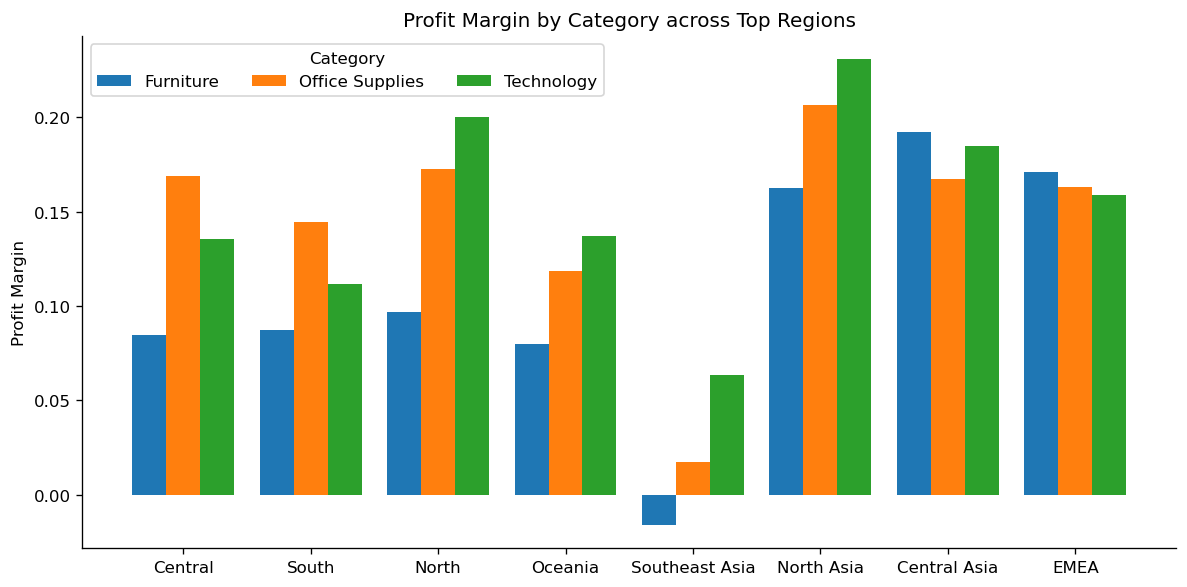

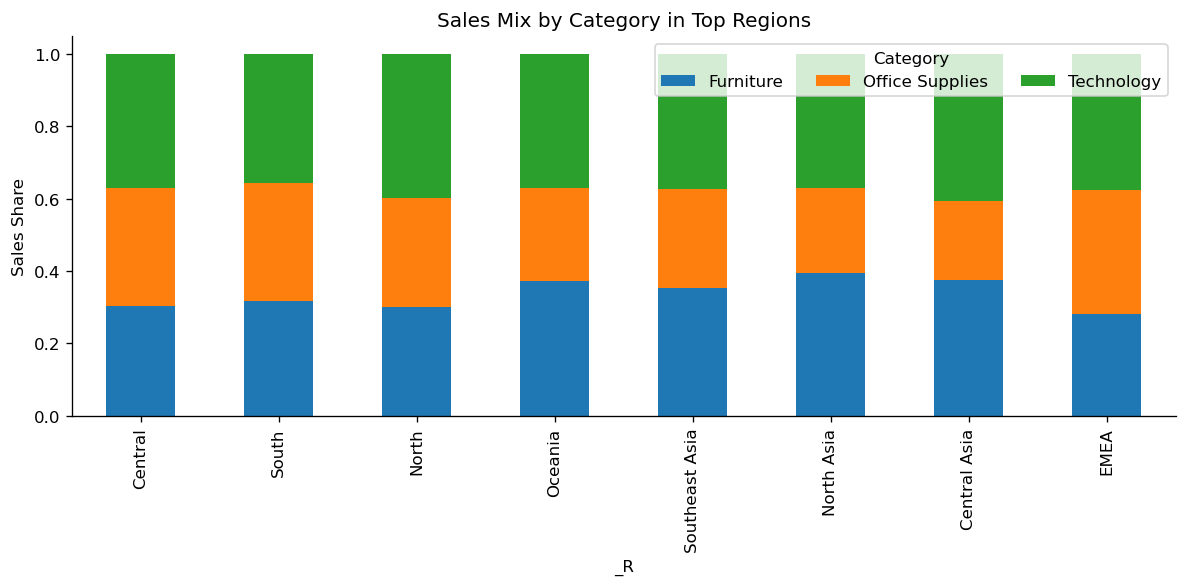

In [7]:
# Require Region & Category
if (col_region is None) or (col_category is None):
    print("Missing Region or Category; skip category analysis.")
else:
    # Clean strings to avoid hidden mismatches (e.g., trailing spaces)
    _tmp = df[[col_region, col_category, col_sales, col_profit]].dropna(subset=[col_region, col_category]).copy()
    _tmp["_R"] = _tmp[col_region].astype(str).str.strip()
    _tmp["_Cat"] = _tmp[col_category].astype(str).str.strip()

    # Region × Category aggregation
    agg_rc = (_tmp.groupby(["_R", "_Cat"])
                .agg(sales=(col_sales, "sum"), profit=(col_profit, "sum"))
                .reset_index())
    agg_rc["margin"] = agg_rc["profit"] / agg_rc["sales"]

    if agg_rc.empty:
        print("No data for Region × Category after aggregation.")
    else:
        # Pick top regions by sales (using cleaned regions)
        top_regions = (_tmp.groupby("_R")[col_sales]
                         .sum().sort_values(ascending=False).head(8).index.tolist())

        sub = agg_rc[agg_rc["_R"].isin(top_regions)]
        if sub.empty:
            print("Top regions have no category rows; try increasing head(8) or drop Top-N.")
        else:
            regions = top_regions
            cats = list(sub["_Cat"].unique())

            # --- Grouped bars: category margins within regions ---
            x = np.arange(len(regions))
            bar_w = 0.8 / max(len(cats), 1)

            plt.figure(figsize=(10, 5))
            for idx, cat in enumerate(cats):
                vals = (sub[sub["_Cat"] == cat]
                        .set_index("_R")
                        .reindex(regions)["margin"].values)
                plt.bar(x + idx * bar_w, vals, width=bar_w, label=str(cat))
            plt.xticks(x + bar_w * (len(cats) - 1) / 2, regions, rotation=0)
            plt.ylabel("Profit Margin")
            plt.title("Profit Margin by Category across Top Regions")
            plt.legend(title="Category", ncol=min(len(cats), 3))
            plt.tight_layout()
            plt.show()

            # --- Robust Sales Mix: row-normalized stacked bars ---
            mask_top = _tmp["_R"].isin(top_regions)
            mix = pd.crosstab(
                index=_tmp.loc[mask_top, "_R"],
                columns=_tmp.loc[mask_top, "_Cat"],
                values=_tmp.loc[mask_top, col_sales],
                aggfunc="sum",
                normalize="index"         # each row sums to 1.0
            ).reindex(regions).fillna(0.0)

            if mix.empty or (mix.sum(axis=1) == 0).all():
                print("Sales mix is empty for the selected top regions. "
                      "Try increasing the number of regions or check Region/Category values.")
            else:
                ax = mix.plot(kind="bar", stacked=True, figsize=(10, 5))
                ax.set_title("Sales Mix by Category in Top Regions")
                ax.set_ylabel("Sales Share")
                ax.legend(title="Category", ncol=min(len(mix.columns), 3))
                plt.tight_layout()
                plt.show()

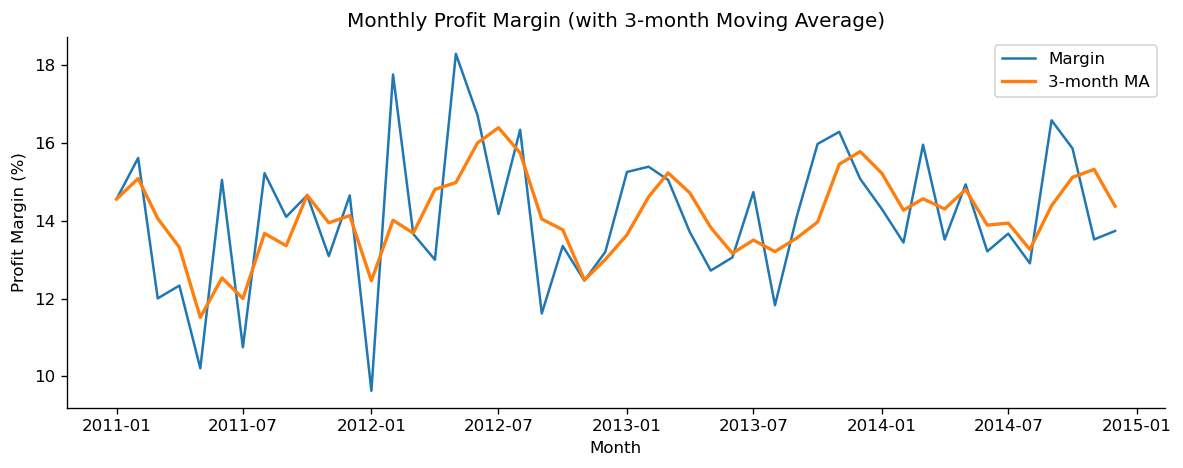

Best 3 months by margin:


,sales,profit,margin
_dt,,,
2012-05-01,203996,37298.00678,0.182837
2012-02-01,98646,17513.01498,0.177534
2012-06-01,251539,42025.66222,0.167074


In [8]:
if col_orderdate:
    dates = pd.to_datetime(df[col_orderdate], errors="coerce")
    ok = dates.notna()
    if ok.sum() == 0:
        print("No parseable dates; check date format.")
    else:
        monthly = (df.loc[ok].assign(_dt=dates[ok])
                     .groupby(pd.Grouper(key="_dt", freq="MS"))
                     .agg(sales=(col_sales,"sum"), profit=(col_profit,"sum")))
        monthly["margin"] = monthly["profit"] / monthly["sales"]
        monthly["margin_ma3"] = monthly["margin"].rolling(3, min_periods=1).mean()

        plt.figure(figsize=(10,4))
        plt.plot(monthly.index, monthly["margin"]*100, label="Margin")
        plt.plot(monthly.index, monthly["margin_ma3"]*100, linewidth=2, label="3-month MA")
        plt.title("Monthly Profit Margin (with 3-month Moving Average)")
        plt.ylabel("Profit Margin (%)"); plt.xlabel("Month"); plt.legend()
        plt.tight_layout(); plt.show()

        print("Best 3 months by margin:")
        display(monthly.sort_values("margin", ascending=False).head(3)[["sales","profit","margin"]])

R^2:  0.701
MAE:  0.122


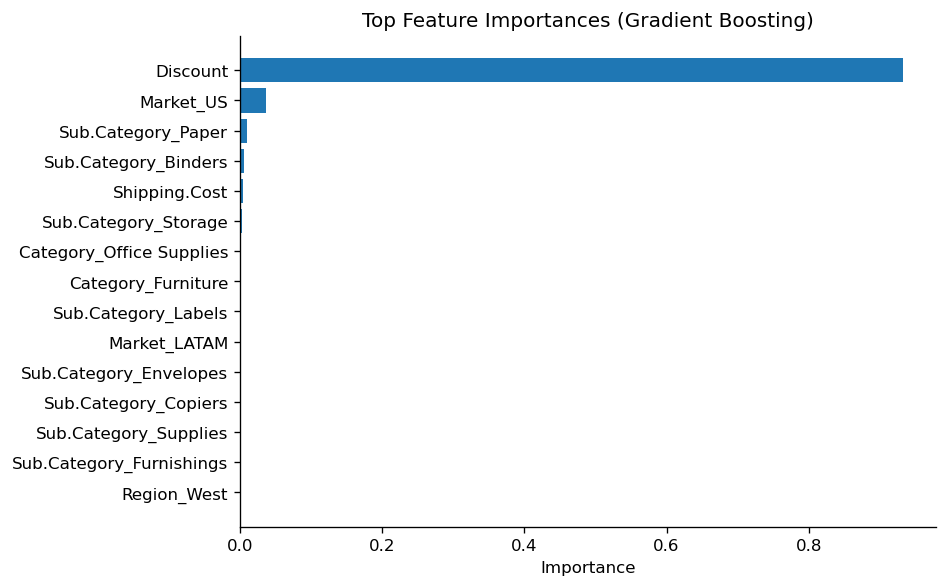

In [9]:
# Auto-install scikit-learn if needed
try:
    from sklearn.model_selection import train_test_split
    from sklearn.compose import ColumnTransformer
    from sklearn.preprocessing import OneHotEncoder, StandardScaler
    from sklearn.pipeline import Pipeline
    from sklearn.metrics import mean_absolute_error, r2_score
    from sklearn.ensemble import GradientBoostingRegressor
except ModuleNotFoundError:
    import sys, subprocess
    print("scikit-learn not found. Installing...")
    subprocess.check_call([sys.executable, "-m", "pip", "install", "-U", "scikit-learn"])
    from sklearn.model_selection import train_test_split
    from sklearn.compose import ColumnTransformer
    from sklearn.preprocessing import OneHotEncoder, StandardScaler
    from sklearn.pipeline import Pipeline
    from sklearn.metrics import mean_absolute_error, r2_score
    from sklearn.ensemble import GradientBoostingRegressor

# Target
y = df["profit_margin"].clip(-0.5, 0.5)

# Features
num_feats = [c for c in [col_discount, col_shipcost, col_qty] if c]
cat_feats = [c for c in [col_region, col_market, col_category, col_subcat, col_shipmode, col_year] if c]
X = df[num_feats + cat_feats].copy()

# Split
Xtr, Xte, ytr, yte = train_test_split(X, y, test_size=0.2, random_state=42)

# Pipeline
pre = ColumnTransformer([
    ("num", StandardScaler(), num_feats),
    ("cat", OneHotEncoder(handle_unknown="ignore"), cat_feats)
])
model = GradientBoostingRegressor(random_state=42)
pipe = Pipeline([("pre", pre), ("gb", model)]).fit(Xtr, ytr)

# Evaluate
pred = pipe.predict(Xte)
print(f"R^2:  {r2_score(yte, pred):.3f}")
print(f"MAE:  {mean_absolute_error(yte, pred):.3f}")

# Feature importances
gb = pipe.named_steps["gb"]
ohe = pipe.named_steps["pre"].named_transformers_.get("cat")
num_names = num_feats
cat_names = list(ohe.get_feature_names_out(cat_feats)) if ohe is not None else []
feat_names = num_names + cat_names

imp = gb.feature_importances_
order = np.argsort(imp)[::-1][:15]

plt.figure(figsize=(8,5))
plt.barh(np.arange(len(order)), imp[order])
plt.yticks(np.arange(len(order)), [feat_names[i] for i in order])
plt.gca().invert_yaxis()
plt.title("Top Feature Importances (Gradient Boosting)")
plt.xlabel("Importance")
plt.tight_layout(); plt.show()

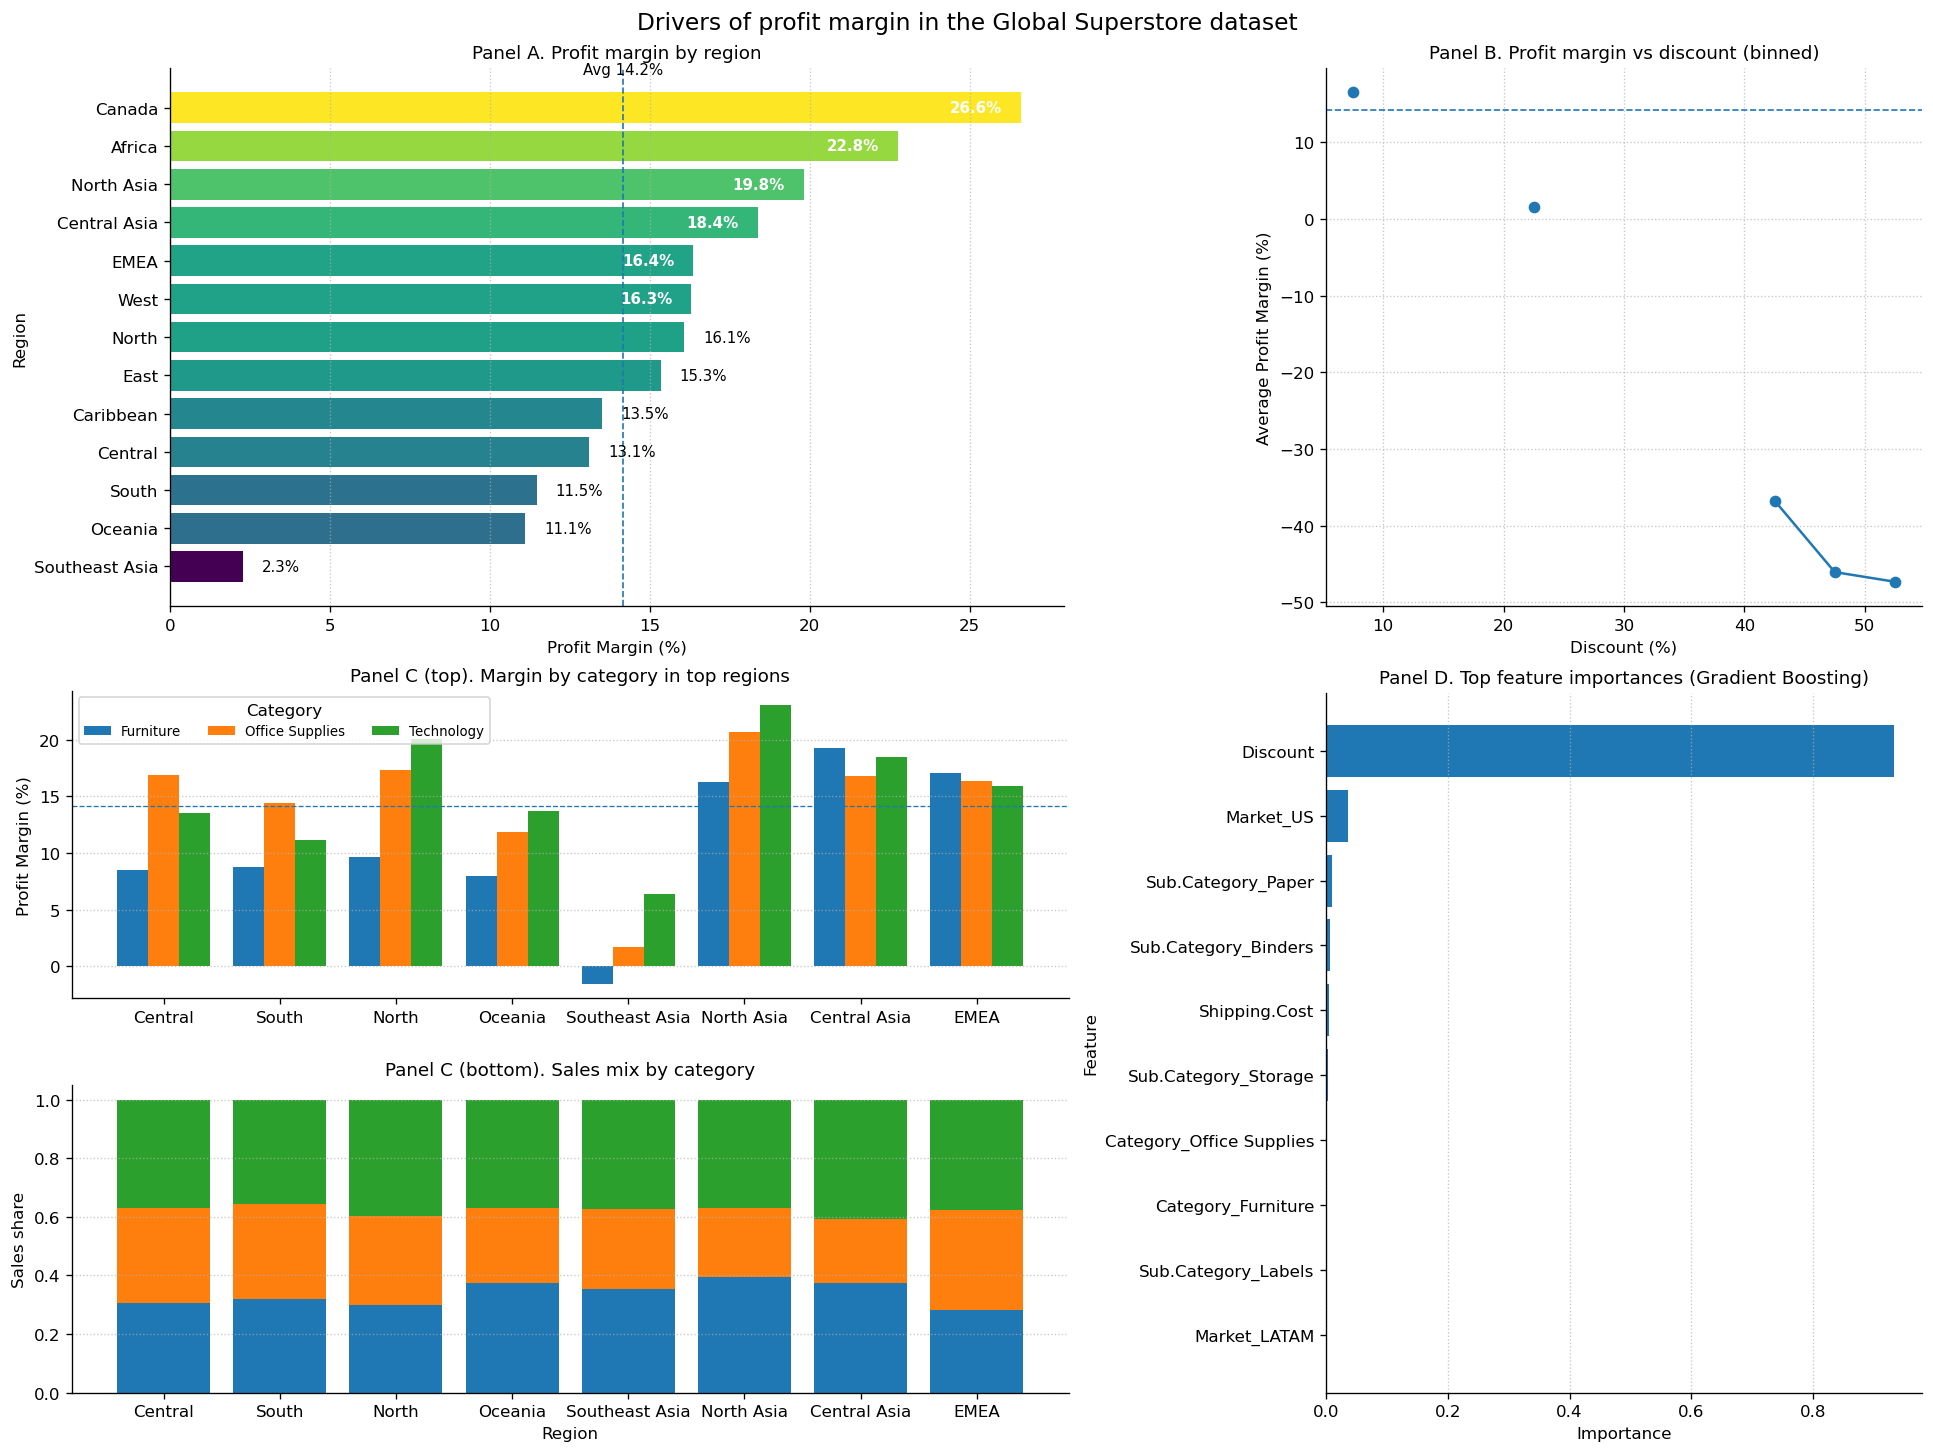

In [10]:
# cell10: Integrated main figure with Panels A–D

import matplotlib.gridspec as gridspec

# ---------- Panel A: Region profit margin ----------
# Reuse `region` and `avg_margin` computed in cell4
region_sorted = region.sort_values("margin", ascending=False).reset_index(drop=True)
y_A = np.arange(len(region_sorted))

cmap = mpl.colormaps['viridis']
norm = mcolors.Normalize(
    vmin=region_sorted["margin"].min(),
    vmax=region_sorted["margin"].max()
)
colors = cmap(norm(region_sorted["margin"].values))

# ---------- Panel B: Discount vs profit margin (binned) ----------
disc_df = df.copy()
if col_discount is not None:
    disc_df = disc_df[[col_discount, "profit_margin"]].dropna()
    disc_df = disc_df[
        (disc_df[col_discount] >= 0) &
        (disc_df[col_discount] <= 0.6)
    ]

    bins = np.arange(0, 0.65, 0.05)
    labels = (bins[:-1] + bins[1:]) / 2  # bin centers
    disc_df["_disc_bin"] = pd.cut(
        disc_df[col_discount],
        bins=bins,
        include_lowest=True
    )
    curve = (
        disc_df.groupby("_disc_bin", observed=False)["profit_margin"]
               .mean()
               .reindex(pd.IntervalIndex.from_breaks(bins))
    )

    x_B = labels[:len(curve)] * 100        # discount in %
    y_B = curve.values * 100              # margin in %
else:
    x_B = np.array([])
    y_B = np.array([])

# ---------- Panel C: Region × Category ----------
if (col_region is not None) and (col_category is not None):
    _tmp = df[[col_region, col_category, col_sales, col_profit]].dropna(
        subset=[col_region, col_category]
    ).copy()
    _tmp["_R"] = _tmp[col_region].astype(str).str.strip()
    _tmp["_Cat"] = _tmp[col_category].astype(str).str.strip()

    agg_rc = (
        _tmp.groupby(["_R", "_Cat"])
            .agg(sales=(col_sales, "sum"),
                 profit=(col_profit, "sum"))
            .reset_index()
    )
    agg_rc["margin"] = agg_rc["profit"] / agg_rc["sales"]

    # Select top regions by total sales
    top_regions = (
        _tmp.groupby("_R")[col_sales]
            .sum()
            .sort_values(ascending=False)
            .head(8)
            .index
            .tolist()
    )

    sub = agg_rc[agg_rc["_R"].isin(top_regions)].copy()
    regions_C = top_regions
    cats_C = list(sub["_Cat"].unique())

    # Pivot for margin and sales mix
    margin_pivot = (
        sub.pivot(index="_R", columns="_Cat", values="margin")
           .reindex(regions_C)
    )

    mask_top = _tmp["_R"].isin(top_regions)
    mix = pd.crosstab(
        index=_tmp.loc[mask_top, "_R"],
        columns=_tmp.loc[mask_top, "_Cat"],
        values=_tmp.loc[mask_top, col_sales],
        aggfunc="sum",
        normalize="index"    # each row sums to 1.0
    ).reindex(regions_C).fillna(0.0)

    # x positions (centers) for regions
    x_C = np.arange(len(regions_C))
    n_cat = len(cats_C)
    bar_w = 0.8 / max(n_cat, 1)
else:
    margin_pivot = None
    mix = None

# ---------- Panel D: Feature importances ----------
# Reuse `imp` and `feat_names` from cell9 (Gradient Boosting)
top_k = 10
order_imp = np.argsort(imp)[::-1][:top_k]
feat_order = [feat_names[i] for i in order_imp]
imp_order = imp[order_imp]

# ---------- Build integrated figure ----------
# Use constrained_layout to reduce overlap between text and axes
fig = plt.figure(figsize=(16, 12), constrained_layout=True)

gs = fig.add_gridspec(
    2, 2,
    height_ratios=[1.0, 1.3],
    width_ratios=[1.5, 1.0]
)

# ==== Panel A: Region profit margin (top-left) ====
axA = fig.add_subplot(gs[0, 0])
axA.barh(y_A, region_sorted["margin"] * 100, color=colors)
axA.set_yticks(y_A)
axA.set_yticklabels(region_sorted[col_region])
axA.set_xlabel("Profit Margin (%)")
axA.set_ylabel("Region")
axA.set_title("Panel A. Profit margin by region", fontsize=11)
axA.grid(axis="x", linestyle=":", linewidth=0.8, alpha=0.7)

# Global average line
axA.axvline(avg_margin * 100, linestyle="--", linewidth=1)
axA.text(
    avg_margin * 100, -0.8,
    f"Avg {avg_margin*100:.1f}%",
    ha="center", va="bottom", fontsize=9
)

# Label each bar with its margin
xmax_A = float(region_sorted["margin"].max()) * 100
for i, v in enumerate(region_sorted["margin"] * 100):
    label = f"{v:.1f}%"
    if v >= avg_margin * 100 + 2:
        axA.text(
            v - 0.6, i, label,
            va="center", ha="right",
            color="white", fontsize=9, fontweight="bold"
        )
    else:
        axA.text(
            min(v + 0.6, xmax_A * 1.02), i, label,
            va="center", ha="left", fontsize=9
        )

axA.invert_yaxis()

# ==== Panel B: Discount vs profit margin (top-right) ====
axB = fig.add_subplot(gs[0, 1])
if len(x_B) > 0:
    axB.plot(x_B, y_B, marker="o")
    axB.axhline(avg_margin * 100, linestyle="--", linewidth=1)
    axB.set_xlabel("Discount (%)")
    axB.set_ylabel("Average Profit Margin (%)")
    axB.set_title("Panel B. Profit margin vs discount (binned)", fontsize=11)
    axB.grid(axis="both", linestyle=":", linewidth=0.8, alpha=0.7)
else:
    axB.text(
        0.5, 0.5, "No discount data",
        ha="center", va="center", transform=axB.transAxes
    )
    axB.set_axis_off()

# ==== Panel C: Region × Category (bottom-left, split into two subplots) ====
gsC = gs[1, 0].subgridspec(2, 1, height_ratios=[1, 1], hspace=0.05)
axC1 = fig.add_subplot(gsC[0, 0])
axC2 = fig.add_subplot(gsC[1, 0], sharex=axC1)

if (margin_pivot is not None) and (mix is not None) and (not margin_pivot.empty):
    # Top subplot: margin by category (grouped bars centered at x_C)
    for idx, cat in enumerate(cats_C):
        offset = (idx - (n_cat - 1) / 2) * bar_w  # symmetric around center
        vals = margin_pivot[cat].values * 100
        axC1.bar(
            x_C + offset,
            vals,
            width=bar_w,
            label=str(cat)
        )
    axC1.axhline(avg_margin * 100, linestyle="--", linewidth=0.8)
    axC1.set_ylabel("Profit Margin (%)")
    axC1.set_title("Panel C (top). Margin by category in top regions", fontsize=11)
    axC1.legend(
        title="Category",
        ncol=min(len(cats_C), 3),
        fontsize=8
    )
    axC1.grid(axis="y", linestyle=":", linewidth=0.8, alpha=0.7)

    # Bottom subplot: sales mix (stacked bars centered at the same x_C)
    bottom = np.zeros(len(regions_C))
    for cat in cats_C:
        vals = mix[cat].values
        axC2.bar(
            x_C,
            vals,
            bottom=bottom,
            label=str(cat)
        )
        bottom += vals

    axC2.set_xticks(x_C)
    axC2.set_xticklabels(regions_C, rotation=0)
    axC2.set_ylabel("Sales share")
    axC2.set_xlabel("Region")
    axC2.set_title("Panel C (bottom). Sales mix by category", fontsize=11)
    axC2.grid(axis="y", linestyle=":", linewidth=0.8, alpha=0.7)
else:
    axC1.text(
        0.5, 0.5, "No Region × Category data",
        ha="center", va="center", transform=axC1.transAxes
    )
    axC2.set_axis_off()

# ==== Panel D: Feature importances (bottom-right) ====
axD = fig.add_subplot(gs[1, 1])
axD.barh(np.arange(len(imp_order)), imp_order)
axD.set_yticks(np.arange(len(imp_order)))
axD.set_yticklabels(feat_order)
axD.invert_yaxis()
axD.set_xlabel("Importance")
axD.set_ylabel("Feature")
axD.set_title("Panel D. Top feature importances (Gradient Boosting)", fontsize=11)
axD.grid(axis="x", linestyle=":", linewidth=0.8, alpha=0.7)

# Overall title for the whole figure
fig.suptitle(
    "Drivers of profit margin in the Global Superstore dataset",
    fontsize=14
)

plt.show()